# QSAR modelling of estrogen receptor alpha ligands

This notebook features a workflow that tries to extract activity-structure information from experimental data. 


## Data Aquisition and Preprocessing

The data are saved in the database (DB) and can be loaded into a [pandas](http://pandas.pydata.org) data frame using the [`compound_db_utils`](https://github.com/martin-sicho/MI_ADM/tree/master/compound_db_utils) package:

In [1]:
import os, pickle, math

from compound_db_utils import settings
from compound_db_utils.data_loaders import fetch_learning_data

RELOAD = False # if True, ignore the pickled data and update from DB

def remove_inconsistent(smiles, ic50s):
    """
    Filter that computes a consensus value for molecules that were tested
    multiple times. The consensus is computed as the median of all 
    available values. 
    
    Molecules with too much variation in the data 
    and too few data points are marked as inconsistent and
    removed entirely.
    """
    
    if int(math.log(ic50s.min(), 10)) != int(math.log(ic50s.max(), 10)) and len(ic50s) < 20:
        return False
    else:
        return ic50s.median()

data = None
if os.path.exists('data.pickle') and not RELOAD:
    data = pickle.load(open('data.pickle', 'br'))
else:
    data = fetch_learning_data(
                ['MI-T-15c25ba4']
                , col_names_map={
                    settings.COMPOUNDS_TABLE + '_smiles' : 'smiles'
                    , settings.BIOACTIVITIES_TABLE + '_value' : 'ic50'
                }
                , create_rdkit_mols=False
                , compute_descriptors=True
                , duplicates_handler= remove_inconsistent
            )
    
pickle.dump(data, open('data.pickle', 'bw'))    

/home/sichom/software/miniconda/envs/MI_ADM/lib/python3.5/site-packages/rdkit/Chem/PeriodicTable.py:131: FutureWarning: split() requires a non-empty pattern match.
  splitLine = blankExpr.split(line)


For each compound, the loaded data provide the canonical [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) string and measured [IC50](https://en.wikipedia.org/wiki/IC50) values. We also chose to compute molecular descriptors for the compounds. Those are saved in the remaining columns (descriptors are computed using the [RDKit](https://rdkit.readthedocs.io/en/latest/) cheminformatics toolkit).

Note that the original dataset may contain duplicate entries, because more experiments were often carried out for one given compound. Here, we decided to remove compounds that show large inconsistencies in their IC50 values and we do not have enough data to safely aggregate the values together.

Because now we only have one SMILES string for each compound, we can use them as the index of the data frame:

In [2]:
data.set_index('smiles', inplace=True)
print(data.shape)
data.head(10)

(1327, 197)


,ic50,MaxAbsPartialCharge,MaxAbsEStateIndex,MinPartialCharge,NumValenceElectrons,MaxPartialCharge,MinAbsPartialCharge,MinEStateIndex,ExactMolWt,MaxEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
smiles,,,,,,,,,,,,,,,,,,,,,
CC(C)c1cccc(N2CCc3cc(O)ccc3C2(C)c2ccc(OCCN3CCCCC3)cc2)c1,31.055,0.507956,10.188795,-0.507956,190,0.118883,0.118883,-0.357919,484.308979,10.188795,...,0,0,0,0,0,0,0,0,0,0
CCc1c(O)ccc2c1O[C@H](c1ccc(OCCN3CCCCC3)cc1)[C@H](c1ccc(O)cc1)S2,4.700,0.507967,10.412779,-0.507967,184,0.140270,0.140270,-0.243942,491.213030,10.412779,...,1,0,0,0,0,0,0,0,0,0
Cc1ccc(S(=O)(=O)N2CCc3cc(O)ccc3C2c2ccc(OCCN3CCCC3)cc2)cc1,24.800,0.507956,13.740342,-0.507956,184,0.243451,0.243451,-3.728670,492.208279,13.740342,...,0,1,0,0,0,0,0,0,0,0
CC1=C(c2ccc(O)cc2)C(=O)c2ccc(O)cc21,6.000,0.507966,12.401821,-0.507966,94,0.194032,0.194032,-0.043343,252.078644,12.401821,...,0,0,0,0,0,0,0,0,0,0
Oc1ccc2c(c1)S[C@H](c1ccco1)[C@H](c1ccc(OCCN3CCCCC3)cc1)O2,35.000,0.507920,9.863330,-0.507920,162,0.143093,0.143093,-0.198525,437.166079,9.863330,...,1,0,0,0,0,0,0,0,0,0
O=c1c2oc3c(Br)cc(O)cc3c2oc2cc(O)cc(O)c12,1260.000,0.507895,12.512773,-0.507895,110,0.239157,0.239157,-0.558945,361.942600,12.512773,...,0,0,0,0,0,0,0,0,0,0
Oc1ccc2c(-c3cccc4ccc(O)cc34)noc2c1,1727.000,0.507943,9.724977,-0.507943,102,0.170701,0.170701,0.139596,277.073893,9.724977,...,0,0,0,0,0,0,0,0,0,0
Cc1cc(O)cc2cc(-c3ccc(O)cc3)oc12,114.000,0.507966,9.552571,-0.507966,90,0.137489,0.137489,0.225635,240.078644,9.552571,...,0,0,0,0,0,0,0,0,0,0
C=Cc1cc(O)cc2ccc(-c3ccc(O)c(F)c3)cc12,527.000,0.507921,13.477906,-0.507921,104,0.164917,0.164917,-0.650697,280.089958,13.477906,...,0,0,0,0,0,0,0,0,0,0


Next, we convert the IC50 values to pIC50 which is defined as the negative logarithm with base 10 of the concentration in moles rather than nanomoles (the default unit for the data in our database): 

In [3]:
import numpy as np

data.ic50 = data.ic50.apply(lambda x : -1.0 * np.log10(x / 1.0e9))

Because of the logarithmic scale, the converted data are now much 'nicer' (note that the higher the pIC50 value, the more potent the compound is as opposed to the raw IC50 value where lower value means higher potency):

Original:
count       1327.000000
mean       12345.786545
std       126395.212707
min            0.200000
25%           55.500000
50%          625.000000
75%         7308.305000
max      3500000.000000
Name: ic50, dtype: float64

Converted:
count    1327.000000
mean        6.295696
std         1.359669
min         2.455932
25%         5.136184
50%         6.204120
75%         7.255725
max         9.698970
Name: ic50, dtype: float64


[]

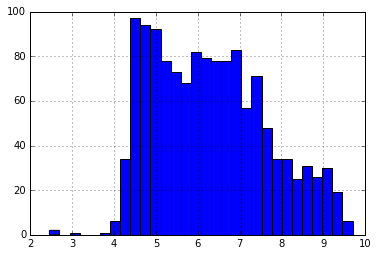

In [4]:
%matplotlib inline
print('Original:')
print(data.ic50.apply(lambda x : np.power(10, - x) * 1.0e9).describe())
print('\nConverted:')
print(data.ic50.describe())
data.ic50.hist(bins=30).plot()

## Feature Selection

Before we attempt to build a model, we remove some variables that might have and adverse effect on the outcome or no effect at all. 

We also define a couple of helper functions that will update our dataset as we go:

In [5]:
def get_removed_feats(data, model):
    """
    This function  finds out the names of the descriptors
    removed by the model.
    """
    
    return data.columns.values[1:][~model.get_support()]

def update_data(data, removed_descriptors, inplace=True):
    """
    Removes the descriptors marked for removal from the data frame.
    """
    if inplace:
        data.drop(removed_descriptors, 1, inplace=True)
        print(data.shape)
        return data
    else:
        new_data = data.drop(removed_descriptors, 1, inplace=False)
        print(new_data.shape)
        return new_data

### Variance Threshold

In the first step we remove features that have zero variance. In other words, the features that have the same value for all of our compounds:

In [6]:
from sklearn.feature_selection import VarianceThreshold

# find the names of the columns with zero variance
var_sel = VarianceThreshold()
var_sel.fit(data.iloc[:,1:])
removed_descriptors = get_removed_feats(data, var_sel)

# update the data frame
update_data(data, removed_descriptors)
data.head(10)

(1327, 172)


,ic50,MaxAbsPartialCharge,MaxAbsEStateIndex,MinPartialCharge,NumValenceElectrons,MaxPartialCharge,MinAbsPartialCharge,MinEStateIndex,ExactMolWt,MaxEStateIndex,...,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
smiles,,,,,,,,,,,,,,,,,,,,,
CC(C)c1cccc(N2CCc3cc(O)ccc3C2(C)c2ccc(OCCN3CCCCC3)cc2)c1,7.507868,0.507956,10.188795,-0.507956,190,0.118883,0.118883,-0.357919,484.308979,10.188795,...,0,0,0,0,0,0,0,0,0,0
CCc1c(O)ccc2c1O[C@H](c1ccc(OCCN3CCCCC3)cc1)[C@H](c1ccc(O)cc1)S2,8.327902,0.507967,10.412779,-0.507967,184,0.140270,0.140270,-0.243942,491.213030,10.412779,...,0,1,0,0,0,0,0,0,0,0
Cc1ccc(S(=O)(=O)N2CCc3cc(O)ccc3C2c2ccc(OCCN3CCCC3)cc2)cc1,7.605548,0.507956,13.740342,-0.507956,184,0.243451,0.243451,-3.728670,492.208279,13.740342,...,0,0,1,0,0,0,0,0,0,0
CC1=C(c2ccc(O)cc2)C(=O)c2ccc(O)cc21,8.221849,0.507966,12.401821,-0.507966,94,0.194032,0.194032,-0.043343,252.078644,12.401821,...,0,0,0,0,0,0,0,0,0,0
Oc1ccc2c(c1)S[C@H](c1ccco1)[C@H](c1ccc(OCCN3CCCCC3)cc1)O2,7.455932,0.507920,9.863330,-0.507920,162,0.143093,0.143093,-0.198525,437.166079,9.863330,...,0,1,0,0,0,0,0,0,0,0
O=c1c2oc3c(Br)cc(O)cc3c2oc2cc(O)cc(O)c12,5.899629,0.507895,12.512773,-0.507895,110,0.239157,0.239157,-0.558945,361.942600,12.512773,...,0,0,0,0,0,0,0,0,0,0
Oc1ccc2c(-c3cccc4ccc(O)cc34)noc2c1,5.762708,0.507943,9.724977,-0.507943,102,0.170701,0.170701,0.139596,277.073893,9.724977,...,0,0,0,0,0,0,0,0,0,0
Cc1cc(O)cc2cc(-c3ccc(O)cc3)oc12,6.943095,0.507966,9.552571,-0.507966,90,0.137489,0.137489,0.225635,240.078644,9.552571,...,0,0,0,0,0,0,0,0,0,0
C=Cc1cc(O)cc2ccc(-c3ccc(O)c(F)c3)cc12,6.278189,0.507921,13.477906,-0.507921,104,0.164917,0.164917,-0.650697,280.089958,13.477906,...,0,0,0,0,0,0,0,0,0,0


### Correlation Filter

Next, we remove the features that are highly correlated with others:

In [7]:
correlated_descs = dict()
def find_correlated(data):
    correlation_matrix = data.iloc[:,2:].corr(method='spearman')
    removed_descs = set()
    all_descs = correlation_matrix.columns.values
    for label in all_descs:
        correlations_abs = correlation_matrix[label].abs()
        mask = (correlations_abs > 0.7).values
        correlated_names = all_descs[mask]
        correlated_descs[label] = set(correlated_names)
        correlated_descs[label].remove(label)
        if label not in removed_descs:
            removed_descs.update(correlated_descs[label])
        
    return removed_descs

update_data(data, find_correlated(data))
pickle.dump(correlated_descs, open('correlated_descs_svr.pickle', 'bw'))
data.head(10)

(1327, 109)


,ic50,MaxAbsPartialCharge,MaxAbsEStateIndex,MinPartialCharge,NumValenceElectrons,MaxPartialCharge,MinEStateIndex,MinAbsEStateIndex,HallKierAlpha,PEOE_VSA1,...,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
smiles,,,,,,,,,,,,,,,,,,,,,
CC(C)c1cccc(N2CCc3cc(O)ccc3C2(C)c2ccc(OCCN3CCCCC3)cc2)c1,7.507868,0.507956,10.188795,-0.507956,190,0.118883,-0.357919,0.336860,-2.98,14.743300,...,0,0,0,0,0,0,0,0,0,0
CCc1c(O)ccc2c1O[C@H](c1ccc(OCCN3CCCCC3)cc1)[C@H](c1ccc(O)cc1)S2,8.327902,0.507967,10.412779,-0.507967,184,0.140270,-0.243942,0.002980,-2.83,19.686781,...,0,1,0,0,0,0,0,0,0,0
Cc1ccc(S(=O)(=O)N2CCc3cc(O)ccc3C2c2ccc(OCCN3CCCC3)cc2)cc1,7.605548,0.507956,13.740342,-0.507956,184,0.243451,-3.728670,0.193604,-2.87,9.843390,...,0,0,1,0,0,0,0,0,0,0
CC1=C(c2ccc(O)cc2)C(=O)c2ccc(O)cc21,8.221849,0.507966,12.401821,-0.507966,94,0.194032,-0.043343,0.043343,-2.55,10.213055,...,0,0,0,0,0,0,0,0,0,0
Oc1ccc2c(c1)S[C@H](c1ccco1)[C@H](c1ccc(OCCN3CCCCC3)cc1)O2,7.455932,0.507920,9.863330,-0.507920,162,0.143093,-0.198525,0.046139,-2.57,18.997404,...,0,1,0,0,0,0,0,0,0,0
O=c1c2oc3c(Br)cc(O)cc3c2oc2cc(O)cc(O)c12,5.899629,0.507895,12.512773,-0.507895,110,0.239157,-0.558945,0.024466,-2.67,24.153884,...,0,0,0,0,0,0,0,0,0,0
Oc1ccc2c(-c3cccc4ccc(O)cc34)noc2c1,5.762708,0.507943,9.724977,-0.507943,102,0.170701,0.139596,0.139596,-3.01,14.736150,...,0,0,0,0,0,0,0,0,0,0
Cc1cc(O)cc2cc(-c3ccc(O)cc3)oc12,6.943095,0.507966,9.552571,-0.507966,90,0.137489,0.225635,0.225635,-2.42,14.630206,...,0,0,0,0,0,0,0,0,0,0
C=Cc1cc(O)cc2ccc(-c3ccc(O)c(F)c3)cc12,6.278189,0.507921,13.477906,-0.507921,104,0.164917,-0.650697,0.181322,-2.81,10.213055,...,0,0,0,0,0,0,0,0,0,0


### Regression Tests

In the last feature selection step, we perform univariate regression tests on the variables (regressors). The cross-correlation between the target variable and
each regressor is evaluated and converted into a p-value and only the top 50% of variables are selected:

In [8]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression

# keep only the descriptors that show significant 
# correlation with the target variable (pIC50)
regre_sele = SelectPercentile(f_regression, percentile=50)
regre_sele.fit(data.iloc[:,1:], data.ic50)
removed_descriptors = get_removed_feats(data, regre_sele)

# update the data frame
update_data(data, removed_descriptors)
data.head(10)

(1327, 55)


,ic50,MaxAbsPartialCharge,MinPartialCharge,NumValenceElectrons,MaxPartialCharge,HallKierAlpha,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,...,fr_aryl_methyl,fr_ester,fr_ether,fr_furan,fr_methoxy,fr_para_hydroxylation,fr_piperzine,fr_pyridine,fr_sulfide,fr_thiazole
smiles,,,,,,,,,,,,,,,,,,,,,
CC(C)c1cccc(N2CCc3cc(O)ccc3C2(C)c2ccc(OCCN3CCCCC3)cc2)c1,7.507868,0.507956,-0.507956,190,0.118883,-2.98,14.743300,18.105906,0.000000,0.000000,...,0,0,1,0,0,0,0,0,0,0
CCc1c(O)ccc2c1O[C@H](c1ccc(OCCN3CCCCC3)cc1)[C@H](c1ccc(O)cc1)S2,8.327902,0.507967,-0.507967,184,0.140270,-2.83,19.686781,35.708896,0.000000,0.000000,...,0,0,2,0,0,0,0,0,1,0
Cc1ccc(S(=O)(=O)N2CCc3cc(O)ccc3C2c2ccc(OCCN3CCCC3)cc2)cc1,7.605548,0.507956,-0.507956,184,0.243451,-2.87,9.843390,18.105906,0.000000,10.023291,...,1,0,1,0,0,0,0,0,0,0
CC1=C(c2ccc(O)cc2)C(=O)c2ccc(O)cc21,8.221849,0.507966,-0.507966,94,0.194032,-2.55,10.213055,11.499024,5.783245,0.000000,...,0,0,0,0,0,0,0,0,0,0
Oc1ccc2c(c1)S[C@H](c1ccco1)[C@H](c1ccc(OCCN3CCCCC3)cc1)O2,7.455932,0.507920,-0.507920,162,0.143093,-2.57,18.997404,40.969569,0.000000,0.000000,...,0,0,2,1,0,0,0,0,1,0
O=c1c2oc3c(Br)cc(O)cc3c2oc2cc(O)cc(O)c12,5.899629,0.507895,-0.507895,110,0.239157,-2.67,24.153884,28.217780,11.166040,11.011811,...,0,0,0,1,0,0,0,0,0,0
Oc1ccc2c(-c3cccc4ccc(O)cc34)noc2c1,5.762708,0.507943,-0.507943,102,0.170701,-3.01,14.736150,17.192952,5.583020,0.000000,...,0,0,0,0,0,0,0,0,0,0
Cc1cc(O)cc2cc(-c3ccc(O)cc3)oc12,6.943095,0.507966,-0.507966,90,0.137489,-2.42,14.630206,22.842291,0.000000,0.000000,...,1,0,0,1,0,0,0,0,0,0
C=Cc1cc(O)cc2ccc(-c3ccc(O)c(F)c3)cc12,6.278189,0.507921,-0.507921,104,0.164917,-2.81,10.213055,5.749512,11.566733,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [20]:
final_desc_set = data.iloc[:,2:].columns.tolist()
pickle.dump(final_desc_set, open('final_desc_set_svr.pickle', 'bw'))

## Model Building

Because we will be building a SVM model, we need to standardize 
the features first. We do so by removing the mean and scaling to unit variance:

In [10]:
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame

scaler = StandardScaler(copy=False)
scaler.fit(data.iloc[:,1:])
scaled_descs = DataFrame(scaler.transform(data.iloc[:,1:]), columns=data.iloc[:,1:].columns)
scaled_descs.head(10)

,MaxAbsPartialCharge,MinPartialCharge,NumValenceElectrons,MaxPartialCharge,HallKierAlpha,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,...,fr_aryl_methyl,fr_ester,fr_ether,fr_furan,fr_methoxy,fr_para_hydroxylation,fr_piperzine,fr_pyridine,fr_sulfide,fr_thiazole
0,0.495945,-0.495256,1.712185,-1.131457,-0.379901,0.240225,0.316641,-0.770601,-0.543028,-0.452622,...,-0.543406,-0.256071,0.471453,-0.327200,-0.295737,-0.377565,-0.199922,-0.234514,-0.351331,-0.143972
1,0.496115,-0.495420,1.536383,-0.881426,-0.197292,1.003983,1.988389,-0.770601,-0.543028,-0.452622,...,-0.543406,-0.256071,1.636476,-0.327200,-0.295737,-0.377565,-0.199922,-0.234514,2.115424,-0.143972
2,0.495945,-0.495256,1.536383,0.324826,-0.245987,-0.516801,0.316641,-0.770601,2.065127,-0.452622,...,0.997406,-0.256071,0.471453,-0.327200,-0.295737,-0.377565,-0.199922,-0.234514,-0.351331,-0.143972
3,0.496109,-0.495414,-1.100652,-0.252917,0.143580,-0.459689,-0.310811,0.332991,-0.543028,-0.452622,...,-0.543406,-0.256071,-0.693571,-0.327200,-0.295737,-0.377565,-0.199922,-0.234514,-0.351331,-0.143972
4,0.495365,-0.494697,0.891774,-0.848433,0.119232,0.897476,2.487993,-0.770601,-0.543028,-0.452622,...,-0.543406,-0.256071,1.636476,2.586856,-0.295737,-0.377565,-0.199922,-0.234514,2.115424,-0.143972
5,0.494966,-0.494313,-0.631846,0.274626,-0.002508,1.694142,1.276961,1.360166,2.322349,-0.452622,...,-0.543406,-0.256071,-0.693571,2.586856,-0.295737,-0.377565,-0.199922,-0.234514,-0.351331,-0.143972
6,0.495739,-0.495057,-0.866249,-0.525672,-0.416423,0.239121,0.229939,0.294783,-0.543028,-0.452622,...,-0.543406,-0.256071,-0.693571,-0.327200,-0.295737,-0.377565,-0.199922,-0.234514,-0.351331,-0.143972
7,0.496108,-0.495413,-1.217854,-0.913940,0.301841,0.222753,0.766454,-0.770601,-0.543028,-0.452622,...,0.997406,-0.256071,-0.693571,2.586856,-0.295737,-0.377565,-0.199922,-0.234514,-0.351331,-0.143972
8,0.495381,-0.494713,-0.807649,-0.593290,-0.172944,-0.459689,-0.856839,1.436629,-0.543028,-0.452622,...,-0.543406,-0.256071,-0.693571,-0.327200,-0.295737,-0.377565,-0.199922,-0.234514,-0.351331,-0.143972
9,0.496115,-0.495420,1.536383,-0.884523,-0.245987,1.792932,1.988389,-0.770601,-0.543028,-0.452622,...,-0.543406,-0.256071,1.636476,-0.327200,-0.295737,-0.377565,-0.199922,-0.234514,2.115424,-0.143972


Next, we create the datasets for cross-validation and testing:

In [11]:
from sklearn.cross_validation import train_test_split

descriptors_train, descriptors_test, pIC50_train, pIC50_test = train_test_split(
    scaled_descs
    , data.ic50
    , test_size=0.4
    , random_state=42
)

and build the model:

In [12]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

param_grid = [
#  {'C': [1, 10, 100, 1000], 'epsilon': [0.0, 0.1, 0.2, 0.3, 0.4], 'kernel': ['linear']},
#  {'C': [1, 10, 100, 1000], 'epsilon': [0.0, 0.1, 0.2, 0.3, 0.4], 'kernel': ['poly'], 'degree' : [2, 3, 4, 5]},
  {'C': [1, 10, 100, 1000], 'epsilon': [0.0, 0.1, 0.2, 0.3, 0.4], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
 ]

model = GridSearchCV(SVR(), param_grid, n_jobs=2, cv=5)
model.fit(descriptors_train, pIC50_train)
model = model.best_estimator_
model.get_params()

{'C': 10,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.3,
 'gamma': 0.01,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Cross-validation Results

Here, we get the cross-validation scores (as the mean coefficient of determination for all folds) and compute the average correlation between the predicted and true values of pIC50:

In [13]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, descriptors_train, pIC50_train, cv=5)
scores_mse = cross_val_score(model, descriptors_train, pIC50_train, cv=5, scoring='mean_squared_error')

print("Mean R^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Mean R: %0.2f (+/- %0.2f)" % (np.sqrt(scores).mean(), np.sqrt(scores).std() * 2))
print("Mean MSE: %0.2f (+/- %0.2f)" % (abs(scores_mse.mean()), scores_mse.std() * 2))

Mean R^2: 0.73 (+/- 0.14)
Mean R: 0.85 (+/- 0.08)
Mean MSE: 0.51 (+/- 0.22)


### Validation Set Results

Finally, we use the trained model to predict the pIC50 values for our test set and use the same metrics as in the above example as well as the mean squared error (MSE) to evaluate the quality of the model:

In [14]:
from sklearn.metrics import mean_squared_error

print("R^2: %0.2f" % model.score(descriptors_test, pIC50_test))
print("R: %0.2f" % np.sqrt(model.score(descriptors_test, pIC50_test)))
print("MSE: %0.2f" %  mean_squared_error(model.predict(descriptors_test), pIC50_test))

R^2: 0.71
R: 0.84
MSE: 0.51


### Error plots

Finally, we take a look at the distribution of errors in predictions among the training set and the test set:

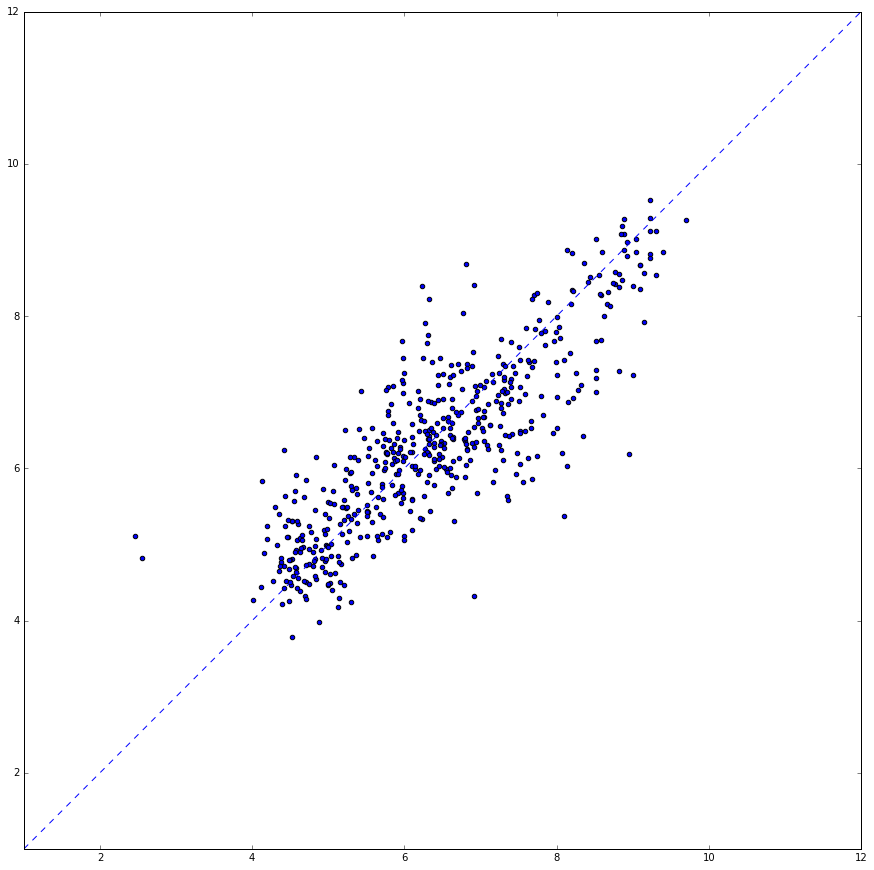

In [15]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 15]
span = (1,12)
axes = plt.gca()
axes.set_xlim(span)
axes.set_ylim(span)

plt.plot((span[0],span[1]), (span[0],span[1]), linestyle='--')

# plt.scatter(
#     pIC50_train
#     , model.predict(descriptors_train)
#     , c='green'
#     , s=20
# )

plt.scatter(
    pIC50_test
    , model.predict(descriptors_test)
    , c='blue'
    , s=20
)

[]

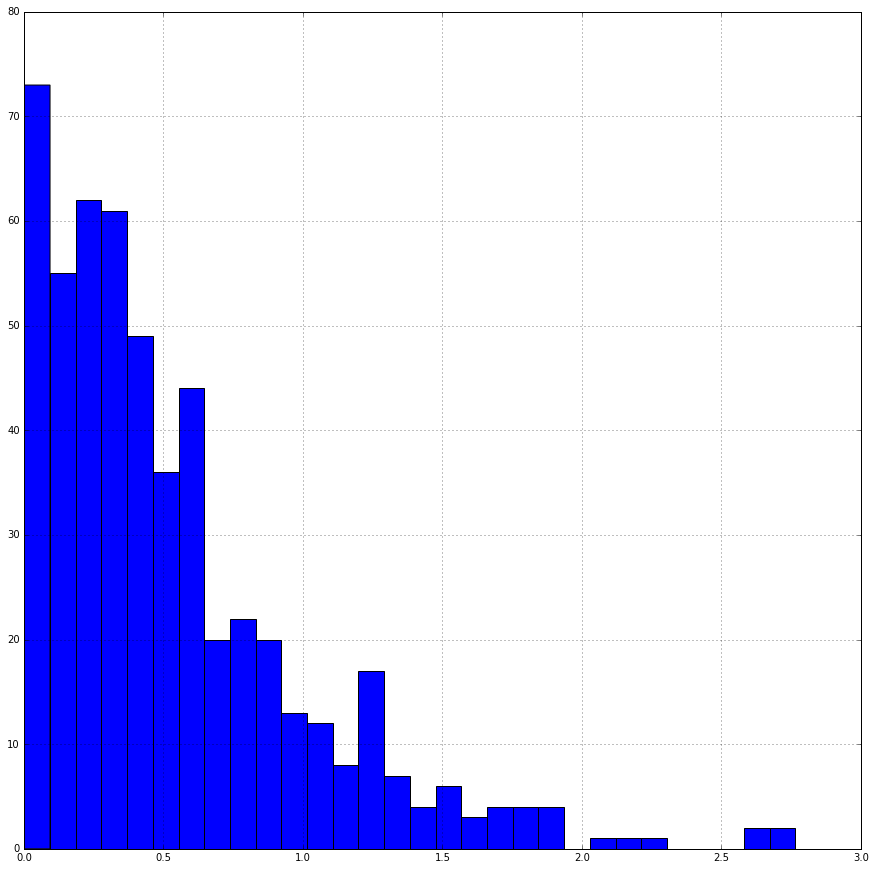

In [16]:
(pIC50_test - model.predict(descriptors_test)).abs().hist(bins=30).plot()

## PCA Analysis

Let's now project our dataset to 3D space using PCA and see if there is any correlation between the postion of molecules and the pIC50 value:

In [17]:
from sklearn import decomposition

n_components = 5

pca = decomposition.PCA(n_components=n_components)
pca.fit(data.iloc[:,1:])
pca_result = pca.transform(data.iloc[:,1:])
eigen_values = pca.explained_variance_ratio_

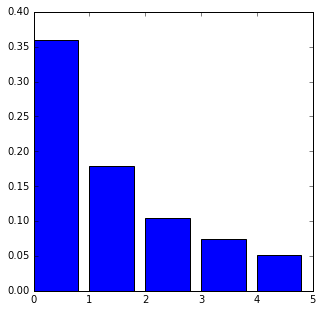

In [18]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.bar(range(pca_result.shape[1]), eigen_values)
plt.show()

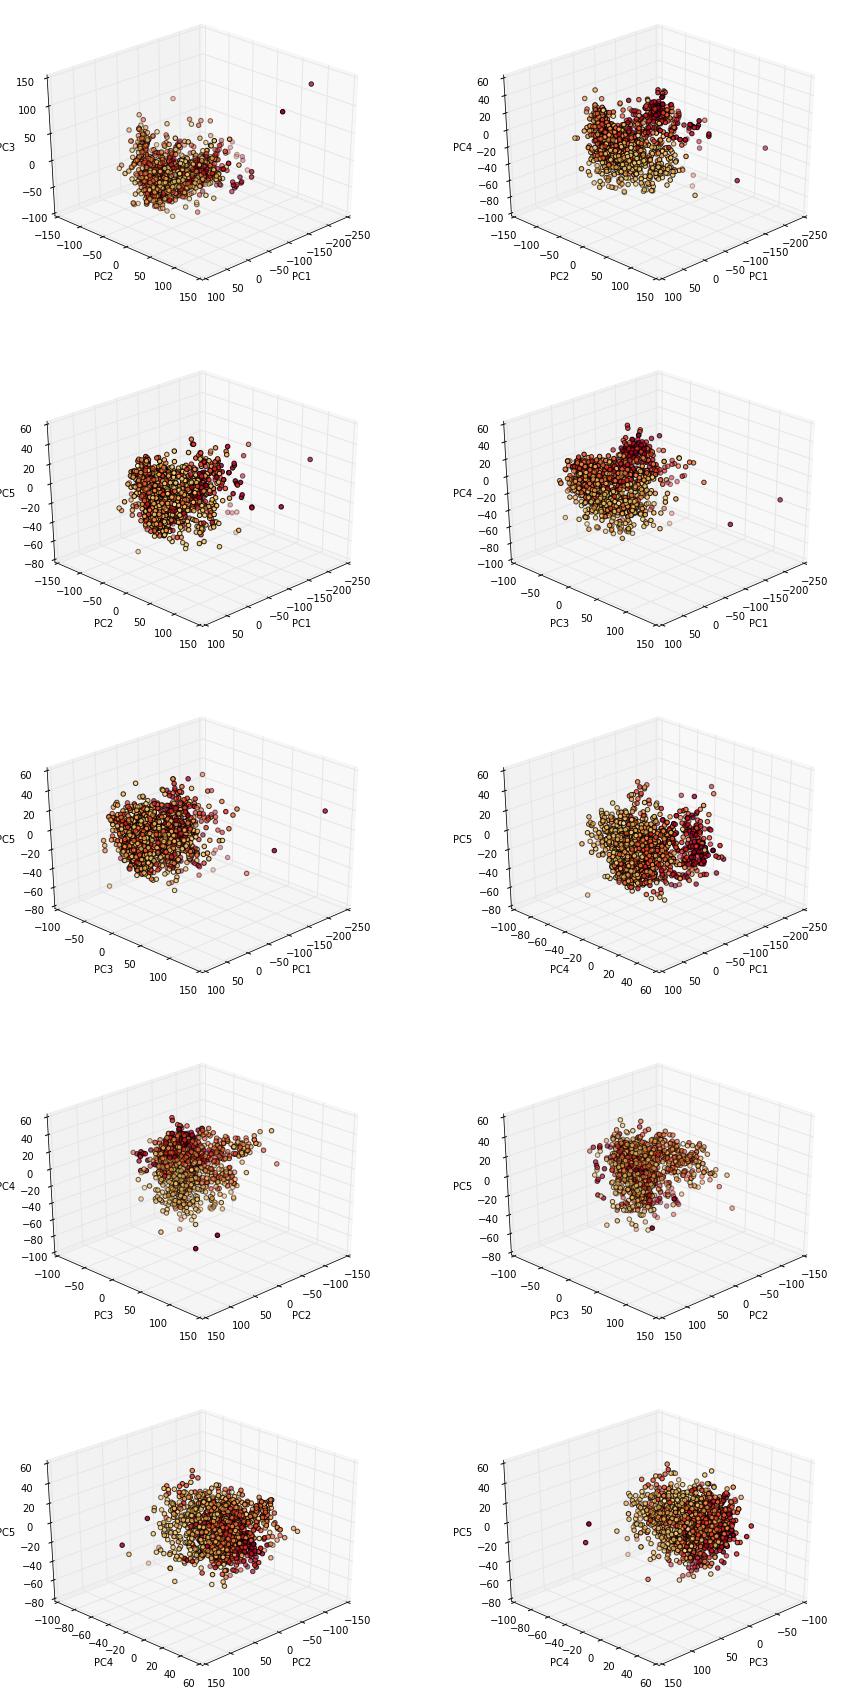

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations

combos = list(combinations(range(n_components), 3))

plt.rcParams["figure.figsize"] = [15, 30]
fig = plt.figure(len(combos) / 2)

for idx, combo in enumerate(combos):
    ax = fig.add_subplot(len(combos) / 2, 2, idx + 1, projection='3d')
    ax.scatter(
        pca_result[:,combo[0]]
        , pca_result[:,combo[1]]
        , pca_result[:,combo[2]]
        , c=data.ic50
        , s=20
        , cmap='YlOrRd' # red are the compounds with higher values of pIC50
    )
    ax.view_init(elev=30, azim=45)
    ax.set_xlabel('PC%s' % (combo[0] + 1))
    ax.set_ylabel('PC%s' % (combo[1] + 1))
    ax.set_zlabel('PC%s' % (combo[2] + 1))

plt.show()